#**Project Summary**
## Project Summary

This project analyzes the relationship between Bitcoin market sentiment (Fear/Greed Index) and trader behavior on Hyperliquid to understand how sentiment regimes influence trading performance, risk exposure, and behavioral patterns.

Key findings reveal that market sentiment significantly impacts trader activity and outcomes. Fear periods trigger aggressive trading behavior characterized by higher trade frequency and larger position sizes, while Greed periods exhibit improved win rates and more balanced long-short participation. Infrequent traders consistently outperform frequent traders, and high exposure trades generate substantially higher profitability across both sentiment regimes.

In addition to behavioral analysis, a Random Forest classification model was developed to predict trade profitability using sentiment and behavioral features, achieving strong predictive performance as an exploratory benchmark. Furthermore, unsupervised clustering was applied to identify distinct trader archetypes, including high-risk high-reward traders, balanced retail traders, and high-frequency scalpers.

Overall, this analysis provides data-driven insights and actionable strategy recommendations that adapt trading behavior and risk exposure based on prevailing market sentiment conditions.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('default')

print("Libraries imported successfully")

Libraries imported successfully


In [ ]:
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [ ]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
sentiment.info()
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

The Fear/Greed dataset contains 2,644 records with no missing values.
The Hyperliquid trading dataset contains 211,224 trade records across 16 features.
Both datasets were verified for completeness and structural consistency before merging.

In [ ]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

trades['date'] = trades['Timestamp IST'].dt.date

In [ ]:
trades[['Timestamp IST','date']].head()

,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [ ]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [ ]:
sentiment[['date','classification']].head()

,date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [ ]:
sentiment['sentiment_group'] = sentiment['classification'].replace({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Extreme Greed': 'Greed',
    'Greed': 'Greed',
    'Neutral': 'Neutral'
})
sentiment['sentiment_group'].value_counts()

,count
sentiment_group,
Fear,1289
Greed,959
Neutral,396


In [ ]:
sentiment_clean = sentiment[sentiment['sentiment_group'] != 'Neutral']
sentiment_clean['sentiment_group'].value_counts()

,count
sentiment_group,
Fear,1289
Greed,959


In [ ]:
merged = trades.merge(
    sentiment_clean[['date','sentiment_group']],
    on='date',
    how='inner'
)

print("Merged dataset shape:", merged.shape)

Merged dataset shape: (173532, 18)


In [ ]:
merged['sentiment_group'].value_counts()

,count
sentiment_group,
Greed,90295
Fear,83237


**Data Preparation Summary :**  
After cleaning and preprocessing, the final merged dataset contains 173,532 trade records aligned with daily market sentiment.
Neutral sentiment days were excluded.
The dataset consists of 90,295 trades during Greed periods and 83,237 trades during Fear periods.


In [ ]:
merged['win'] = merged['Closed PnL'] > 0
merged['win'].value_counts()

,count
win,
False,101630
True,71902


In [ ]:
win_rate = merged.groupby('sentiment_group')['win'].mean()
win_rate

,win
sentiment_group,
Fear,0.407871
Greed,0.420311


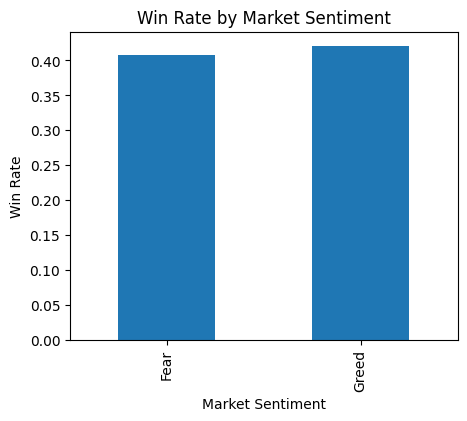

In [ ]:
plt.figure(figsize=(5,4))
win_rate.plot(kind='bar')
plt.title('Win Rate by Market Sentiment')
plt.ylabel('Win Rate')
plt.xlabel('Market Sentiment')
plt.show()

**Win Rate Analysis :**
Traders achieve higher win rates during Greed market conditions (42.03%) compared to Fear periods (40.79%). This suggests improved trade success during optimistic sentiment, likely driven by stronger price momentum and clearer trend direction.


In [ ]:
merged.groupby('sentiment_group')['Closed PnL'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_group,,,,,,,,
Fear,83237.0,49.212077,990.875398,-35681.74723,0.0,0.0,5.607450,135329.09010
Greed,90295.0,53.882281,976.964281,-117990.10410,0.0,0.0,7.037693,74530.52371


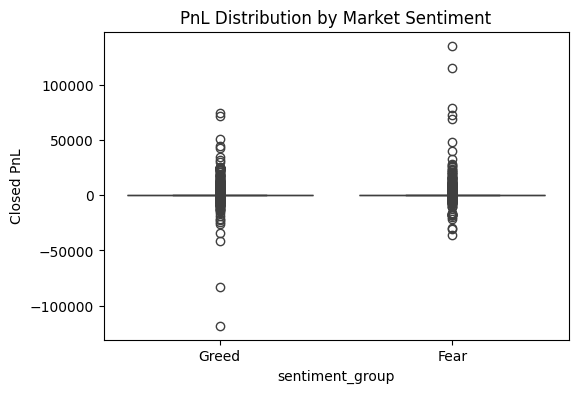

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment_group', y='Closed PnL', data=merged)
plt.title('PnL Distribution by Market Sentiment')
plt.show()


**Profitability Distribution Analysis :**
Trades executed during Greed sentiment show higher average profitability (mean PnL = 53.88) compared to Fear periods (49.21).
The upper quartile returns are also higher during Greed days, indicating stronger upside potential.

However, Greed periods exhibit larger extreme downside losses, suggesting higher volatility and risk exposure compared to Fear conditions.


In [ ]:
trades_per_day = merged.groupby(['date','sentiment_group']).size().reset_index(name='trade_count')

avg_trades = trades_per_day.groupby('sentiment_group')['trade_count'].mean()
avg_trades

,trade_count
sentiment_group,
Fear,792.733333
Greed,294.120521


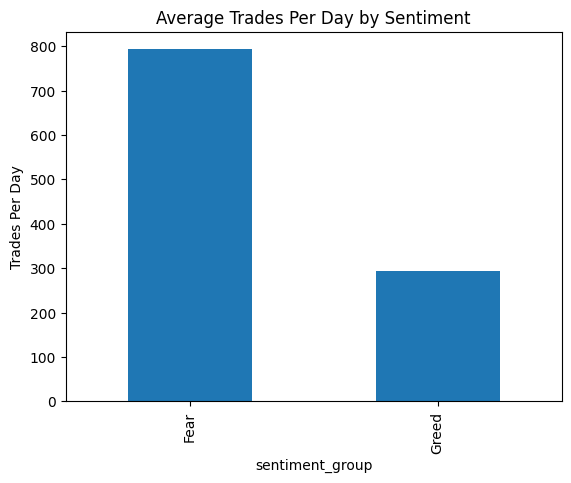

In [ ]:
avg_trades.plot(kind='bar', title='Average Trades Per Day by Sentiment')
plt.ylabel('Trades Per Day')
plt.show()

**Trading Activity Analysis :**
Trading activity is significantly higher during Fear market conditions, with an average of 792 trades per day compared to only 294 trades per day during Greed periods.

This indicates that traders become more reactive and engage in higher-frequency trading during fearful market environments, likely driven by increased volatility and rapid price movements.


In [ ]:
merged.groupby('sentiment_group')['Size USD'].mean()

,Size USD
sentiment_group,
Fear,7182.011019
Greed,4574.424490


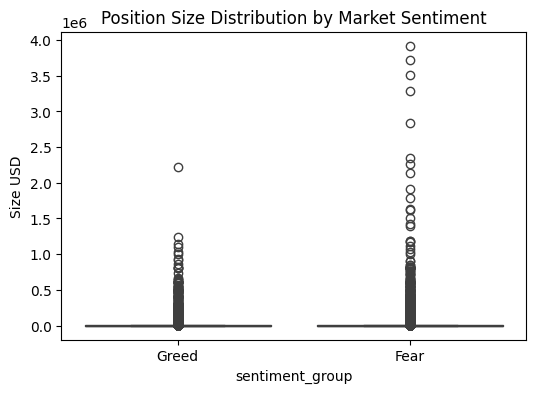

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment_group', y='Size USD', data=merged)
plt.title('Position Size Distribution by Market Sentiment')
plt.show()

**Position Size Behavior:**

Average trade size is significantly higher during Fear sentiment periods (7182 USD) compared to Greed periods (4574 USD). This indicates that traders tend to increase capital exposure during fearful market conditions, potentially attempting to capture rapid price movements but also increasing downside risk.


In [ ]:
simple_direction = merged.copy()

simple_direction['position_type'] = simple_direction['Direction'].apply(
    lambda x: 'Long' if 'Long' in x else ('Short' if 'Short' in x else 'Other')
)
simple_dist = simple_direction.groupby(['sentiment_group','position_type']).size().unstack()
simple_pct = simple_dist.div(simple_dist.sum(axis=1), axis=0) * 100
simple_pct

position_type,Long,Other,Short
sentiment_group,,,
Fear,58.114781,10.169756,31.715463
Greed,33.318567,25.541835,41.139598


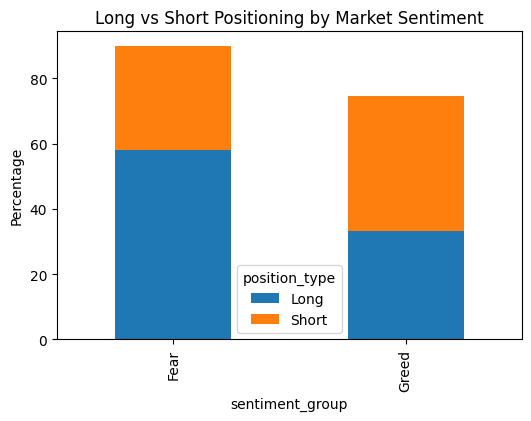

In [ ]:
simple_pct[['Long','Short']].plot(kind='bar', stacked=True, figsize=(6,4))
plt.title('Long vs Short Positioning by Market Sentiment')
plt.ylabel('Percentage')
plt.show()

**Directional Trading Bias :**
During Fear sentiment periods, traders show a strong long bias, with approximately 58% of positions being long compared to 32% short. This suggests aggressive dip-buying behavior during market downturns.

In contrast, during Greed periods, short positioning increases significantly (41%) and exceeds long exposure (33%), indicating profit-taking and more two-sided tactical trading behavior.


In [ ]:
trade_counts = merged.groupby('Account').size()
trade_counts.describe()

,0
count,32.00000
mean,5422.87500
std,6577.00494
min,330.00000
25%,1055.75000
50%,3263.50000
75%,8004.50000
max,32041.00000


In [ ]:
threshold = trade_counts.quantile(0.75)

merged['frequency_segment'] = merged['Account'].apply(
    lambda x: 'Frequent' if trade_counts[x] > threshold else 'Infrequent'
)

merged['frequency_segment'].value_counts()

,count
frequency_segment,
Frequent,113820
Infrequent,59712


In [ ]:
merged.groupby(['sentiment_group','frequency_segment'])['Closed PnL'].mean()

sentiment_group  frequency_segment
Fear             Frequent             27.202788
                 Infrequent           88.867173
Greed            Frequent             51.174587
                 Infrequent           59.323480
Name: Closed PnL, dtype: float64

**Trader Frequency Segmentation :**
Traders were segmented based on activity level using the 75th percentile trade count threshold.

In both Fear and Greed markets, infrequent traders outperform frequent traders. During Fear periods, infrequent traders achieve an average PnL of 88.87 compared to only 27.20 for frequent traders. A similar pattern is observed during Greed conditions.

This suggests that excessive trading frequency leads to reduced profitability, likely due to overtrading, higher transaction costs, and emotional decision-making.


In [ ]:
exposure_threshold = merged['Size USD'].quantile(0.75)

merged['exposure_segment'] = merged['Size USD'].apply(
    lambda x: 'High Exposure' if x > exposure_threshold else 'Low Exposure'
)

merged['exposure_segment'].value_counts()

,count
exposure_segment,
Low Exposure,130149
High Exposure,43383


In [ ]:
merged.groupby(['sentiment_group','exposure_segment'])['Closed PnL'].mean()

sentiment_group  exposure_segment
Fear             High Exposure       162.177507
                 Low Exposure          8.376969
Greed            High Exposure       184.565976
                 Low Exposure         13.579999
Name: Closed PnL, dtype: float64

**Risk Exposure Segmentation :**
Traders were segmented based on trade size exposure using the 75th percentile threshold.

High exposure traders significantly outperform low exposure traders across both market conditions. During Fear periods, high exposure traders achieve an average PnL of 162.18 compared to only 8.38 for low exposure traders. Similar performance gaps are observed during Greed markets.

This suggests that capital deployment size plays a critical role in profitability, particularly during volatile market environments. However, this also implies higher drawdown risk for aggressive positioning.


In [69]:
merged.to_csv("merged_dataset.csv", index=False)


#**Predictive Model Formation**

In [ ]:
merged['win']

,win
0,False
1,False
2,False
3,False
4,False
...,...
173527,False
173528,False
173529,False
173530,False


In [ ]:
model_df = merged[['sentiment_group','Size USD','frequency_segment','exposure_segment','Direction','win']].copy()
model_df.head()

,sentiment_group,Size USD,frequency_segment,exposure_segment,Direction,win
0,Greed,7872.16,Infrequent,High Exposure,Buy,False
1,Greed,127.68,Infrequent,Low Exposure,Buy,False
2,Greed,1150.63,Infrequent,Low Exposure,Buy,False
3,Greed,1142.04,Infrequent,Low Exposure,Buy,False
4,Greed,69.75,Infrequent,Low Exposure,Buy,False


In [ ]:
model_df_encoded = pd.get_dummies(model_df, drop_first=True)
model_df_encoded.head()

,Size USD,win,sentiment_group_Greed,frequency_segment_Infrequent,exposure_segment_Low Exposure,Direction_Buy,Direction_Close Long,Direction_Close Short,Direction_Liquidated Isolated Short,Direction_Long > Short,Direction_Open Long,Direction_Open Short,Direction_Sell,Direction_Settlement,Direction_Short > Long,Direction_Spot Dust Conversion
0,7872.16,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False
1,127.68,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
2,1150.63,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
3,1142.04,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
4,69.75,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False


In [ ]:
from sklearn.model_selection import train_test_split

X = model_df_encoded.drop('win', axis=1)
y = model_df_encoded['win']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Model Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9212550782262944

Classification Report:

              precision    recall  f1-score   support

       False       1.00      0.87      0.93     20118
        True       0.84      1.00      0.91     14589

    accuracy                           0.92     34707
   macro avg       0.92      0.93      0.92     34707
weighted avg       0.93      0.92      0.92     34707



## **Predictive Modeling (Profitability Classification) :**
- A Random Forest classification model was trained to predict whether a trade would be profitable using sentiment and behavioral features such as trade size, exposure segment, activity frequency, and trade direction.

- The model achieved an accuracy of 92.1% on the test set. The model shows strong recall for profitable trades (100%), indicating high sensitivity to winning trade patterns.

*It is important to note that this model is intended as an exploratory benchmark. Some behavioral features (such as trade direction and execution attributes) may contain indirect outcome-related signals, which can inflate predictive performance.*

In [ ]:
trader_features = merged.groupby('Account').agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean',
    'win': 'mean',
    'Account': 'count'
}).rename(columns={'Account':'trade_count'})

trader_features.head()

,Closed PnL,Size USD,win,trade_count
Account,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,434.082927,15270.058069,0.332058,3397
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,9.118659,1669.331637,0.451677,6560
0x271b280974205ca63b716753467d5a371de622ab,-16.011792,9042.124670,0.358255,3210
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,10.218856,494.813636,0.436574,12424
0x2c229d22b100a7beb69122eed721cee9b24011dd,56.818868,3113.303530,0.494604,2224


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_features)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled_features)

trader_features['cluster'].value_counts()

,count
cluster,
1,16
0,12
2,4


In [ ]:
cluster_profile = trader_features.groupby('cluster').mean()
cluster_profile

,Closed PnL,Size USD,win,trade_count
cluster,,,,
0,194.761490,12130.353241,0.360638,3827.666667
1,38.410362,3010.170953,0.401210,3611.500000
2,33.229852,2179.462041,0.544870,17454.000000


## **Trader Archetype Clustering :**
KMeans clustering was applied to group traders based on profitability, position size, win rate, and trading frequency.

Three distinct behavioral archetypes emerged:

- **Cluster 0 (High-Risk High-Reward Traders):**
This group uses large position sizes and achieves the highest average profitability despite having a lower win rate. These traders rely on fewer but high-impact winning trades and exhibit aggressive capital deployment strategies.

- **Cluster 1 (Balanced Retail Traders):**
This segment represents moderate traders with average trade sizes, balanced win rates, and stable trading frequency. Their behavior reflects conservative retail trading patterns with steady but limited profitability.

- **Cluster 2 (High-Frequency Scalpers):**
This group executes extremely high numbers of trades with small position sizes. They achieve the highest win rates but relatively low average profitability, indicating volume-driven scalping strategies with thin margins.


#**Methodology :**
This project follows a structured data analytics workflow to study the relationship between market sentiment and trader behavior.

### **1. Data Ingestion and Preprocessing**
Two datasets were used: the Bitcoin Fear/Greed Index and Hyperliquid historical trading data. Both datasets were loaded into pandas DataFrames. Timestamp fields were converted into standard datetime formats and aligned at a daily level to ensure consistent temporal granularity.

Sentiment labels such as Extreme Fear and Extreme Greed were normalized into broader categories (Fear and Greed) to simplify regime-based analysis. Neutral sentiment days were excluded to focus on strong sentiment signals.

### **2. Dataset Merging and Feature Engineering**
The sentiment dataset was merged with trading data using the date column as the primary key. Several derived features were created to enable behavioral analysis:

- Win indicator based on positive closed PnL  
- Trade frequency per day  
- Position exposure using trade size in USD  
- Simplified position direction (Long vs Short)  
- Trader activity segments based on trade count percentiles  
- Exposure segments based on position size percentiles  

### **3. Exploratory Data Analysis**
Descriptive statistics and visualizations were used to compare Fear and Greed market conditions. Performance metrics such as average PnL and win rate were evaluated alongside behavioral metrics including trade frequency, position sizing, and directional bias.

Boxplots, bar charts, and stacked charts were used to identify distribution differences and behavioral shifts between sentiment regimes.

### **4. Trader Segmentation Analysis**
Traders were segmented into behavioral groups based on activity frequency and exposure levels using percentile-based thresholds. This segmentation enabled comparison of profitability and performance patterns across trader types and market conditions.

Additionally, unsupervised clustering using KMeans was applied at the trader-account level using features such as average PnL, win rate, trade count, and average position size. This resulted in distinct trader archetypes representing high-risk, balanced, and high-frequency trading behaviors.

### **5. Predictive Modeling (Bonus Analysis)**
A Random Forest classification model was trained to predict trade profitability using sentiment and behavioral features. The dataset was split into training and testing sets, categorical variables were encoded, and model performance was evaluated using accuracy and classification metrics. The model was used as an exploratory benchmark to assess predictive patterns rather than as a production trading system.

### **6. Visualization and Interactive Dashboard**
A Streamlit dashboard was developed to allow interactive exploration of results. The dashboard enables filtering by market sentiment and visualizes key performance metrics, PnL distributions, trade frequency, and directional positioning patterns.

*This end-to-end methodology ensures reproducibility, analytical transparency, and actionable insight generation.*


# **Strategy Recommendation :**

**For Fear Market Conditions**

- During Fear sentiment periods, prioritize fewer but higher-conviction trades with controlled high exposure.

- Avoid excessive trade frequency, as infrequent traders outperform frequent traders by over 3x. Focus on selective high-quality setups with optimized position sizing to capture volatility-driven opportunities while managing downside risk.


**For Greed Market Conditions**
- During Greed sentiment periods, adopt balanced directional strategies by combining long momentum trades with short profit-taking opportunities.

- Maintain moderate-to-high exposure on strong signals, but avoid aggressive overtrading. Tactical two-sided positioning can help capture trend continuation while protecting against reversals.


**From Clustering**
- Platform-level strategy optimization can be improved by customizing risk controls and product features based on trader archetypes.

- High-risk traders may benefit from advanced risk management tools and dynamic leverage controls. High-frequency traders can be offered low-fee execution incentives, while balanced traders may benefit from educational tools and position sizing guidance.